In [1]:
import random
import math
import timeit
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange, stencil

In [2]:
from common import (
    initialize_fields,
    plot_field
)

In [3]:
NX = 128
NY = 128
NZ = 80
N_ITER = 50

# Accelerate with Numba

From Numba docs:

> Numba is a just-in-time compiler for Python that works best on code that uses NumPy arrays and functions, and loops. (...) When a call is made to a Numba-decorated function it is compiled to machine code “just-in-time” for execution and all or part of your code can subsequently run at native machine code speed!

> With a few simple annotations, array-oriented and math-heavy Python code can be just-in-time optimized to performance similar
as C, C++ and Fortran, without having to switch languages or Python interpreters.

The goal of this notebook is to show how we can use Numba and check whether we observe a performance gain compared to the results in [the first Jupyter notebook](1_lists_numpy.ipynb). We will restrict the tests to the cases where we used Numpy arrays. And we will test the following:

1. `@numba.jit(nopython=True)` or `@numba.njit`
2. `numba.prange` together with `parallel=True`
3. `@numba.stencil`
4. `@cuda.jit`

Again, from the Numba docs:

> The Numba @jit decorator fundamentally operates in two compilation modes, nopython mode and object mode. (...) The behaviour of the nopython compilation mode is to essentially compile the decorated function so that it will run entirely without the involvement of the Python interpreter. This is the recommended and best-practice way to use the Numba jit decorator as it leads to the best performance.

> Assuming Numba can operate in nopython mode, or at least compile some loops, it will target compilation to your
specific CPU. Speed up varies depending on application but can be one to two orders of magnitude.

# Pointwise stencil

## Arrays with loops

Functions in this notebook are a bit different from the previous notebook. In the first place they don't use the timeit.default_timer() function, since Numba cannot deal with this function. For the same reason, the option to plot out_field is also removed, but out_field is now always returned.

In [4]:
@jit(nopython=True)
def array_numba_pointwise(in_field, out_field):
    for iter in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = in_field[k, j, i]
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field

    return out_field

One has to be carefull to measure the performance using Numba.

> A really common mistake when measuring performance is to not account for the above behaviour and to time code
once with a simple timer that includes the time taken to compile your function in the execution time.

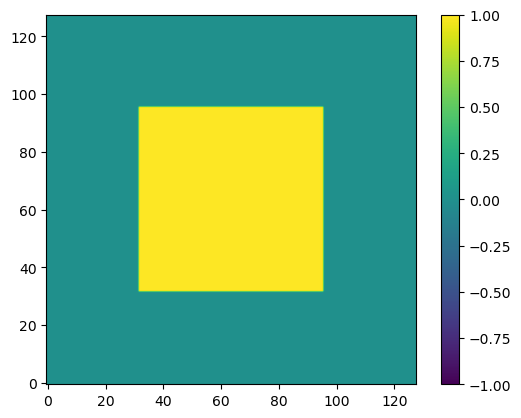

In [5]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
plot_field(in_field)

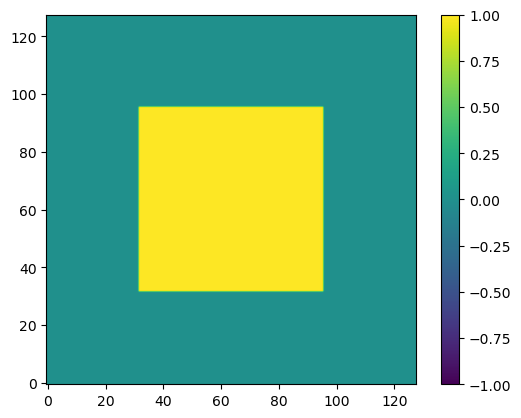

In [6]:
# This call is just so that Numba compiles the function before we benchmark
out_field = array_numba_pointwise(in_field, out_field)
plot_field(out_field)

In [7]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_numba_pointwise(in_field, out_field)

10.5 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Numba works! It is about **~160x faster** that pure python code (lists) and **~535x faster** than using numpy arrays while keeping the `for` loops. And just by adding a simple decorator on top of the function definition! It is even faster than the pure numpy copy code, but in the same order of magnitude.

| Function                  | Time    |
|:--------------------------|--------:|
| `list_pointwise()`        |  1.68s  |
| `array_pointwise()`       |  5.62s  |
| `numpy_pointwise()`       |  11.4ms |
| `array_numba_pointwise()` |  10.5ms |

In [8]:
@jit(nopython=True)
def array_numba_sin_pointwise(in_field, out_field):
    for iter in range(N_ITER):
        for k in range(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = math.sin(in_field[k, j, i])
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field

    return out_field

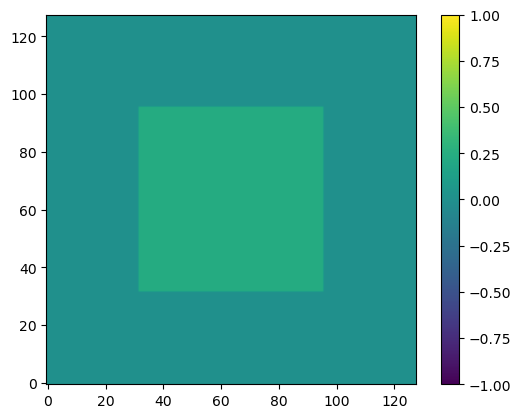

In [9]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
out_field = array_numba_sin_pointwise(in_field, out_field)
plot_field(out_field)

In [10]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_numba_sin_pointwise(in_field, out_field)

336 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Applying `sin()` instead of a simple copy we also observed a very noticable increase in performance. It is **~7x faster** than pure python code (lists) and **~22x faster** than numpy arrays with `for` loops. Unfortunately, it is still slower than running the vectorized numpy code.

| Function                      | Time   |
|:------------------------------|-------:|
| `list_sin_pointwise()`        |  2.51s |
| `array_sin_pointwise()`       |  7.94s |
| `numpy_sin_pointwise()`       |  348ms |
| `array_numba_sin_pointwise()` |  353ms |

We can improve even more our performance by using all the cores of the CPU. `@jit` support the argument `parallel=True`.

> If code contains operations that are parallelisable (and supported) Numba can compile a version that will run in parallel
on multiple native threads (no GIL!).

In addition, we can do something similar to what we did with OpenMP and Fortran.

> Numba parallel execution also has support for explicit parallel loop declaration similar to that in OpenMP. To indicate
that a loop should be executed in parallel the numba.prange function should be used, this function behaves like Python
range and if parallel=True is not set it acts simply as an alias of range.

In [11]:
@jit(nopython=True, parallel=True)
def array_numba_parallel_sin_pointwise(in_field, out_field):
    for iter in range(N_ITER):
        # We use prange instead of range for the Z axis
        for k in prange(NZ):
            for j in range(NY):
                for i in range(NX):
                    out_field[k, j, i] = math.sin(in_field[k, j, i])
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field

    return out_field

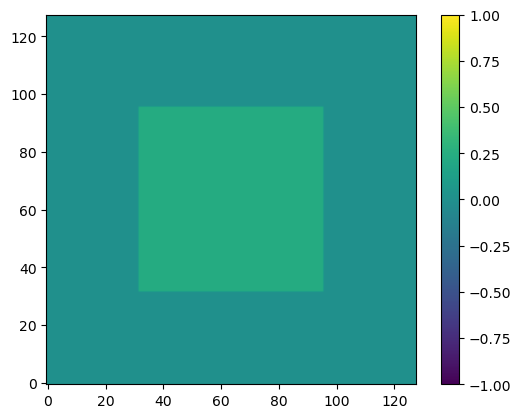

In [12]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
out_field = array_numba_parallel_sin_pointwise(in_field, out_field)
plot_field(out_field)

In [13]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
array_numba_parallel_sin_pointwise(in_field, out_field)

45.2 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Using `prange` and `parallel=True` we can make this code **~8x faster** that the vectorized numpy code. This speedup, however, depends on the number of cores we have available.

| Function                               | Time   |
|:---------------------------------------|-------:|
| `list_sin_pointwise()`                 | 2.51s  |
| `array_sin_pointwise()`                | 7.94s  |
| `numpy_sin_pointwise()`                | 348ms  |
| `array_numba_sin_pointwise()`          | 353ms  |
| `array_numba_parallel_sin_pointwise()` | 41.5ms |

## Arrays without loops

In [14]:
@jit(nopython=True)
def numpy_numba_pointwise(in_field, out_field):
    for iter in range(N_ITER):
        out_field = in_field.copy()
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field

    return out_field

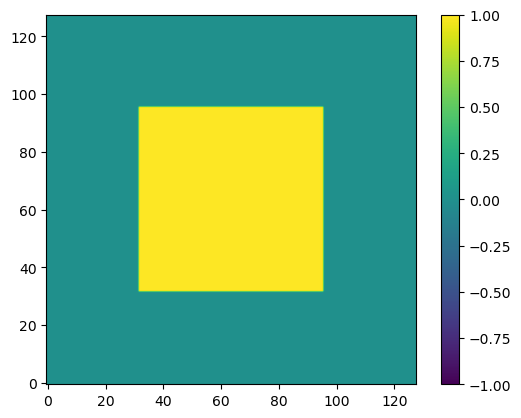

In [15]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
numpy_numba_pointwise(in_field, out_field)
plot_field(out_field)

In [16]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
numpy_numba_pointwise(in_field, out_field)

16.3 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


We cannot improve the time in this case. Actually, the performance is slighly worse (~1ms) which may be due to the overhead of calling the code compiled by Numba, which seems to be less optimized than the NumPy `copy()` function.

| Function                  | Time   |
|:--------------------------|-------:|
| `list_pointwise()`        | 1.68s  |
| `array_pointwise()`       | 5.62s  |
| `numpy_pointwise()`       | 11.4ms |
| `array_numba_pointwise()` | 10.5ms |
| `numpy_numba_pointwise()` | 11.8ms |

In [17]:
@jit(nopython=True)
def numpy_numba_sin_pointwise(in_field, out_field):
    for iter in range(N_ITER):
        out_field = np.sin(in_field)
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field

    return out_field

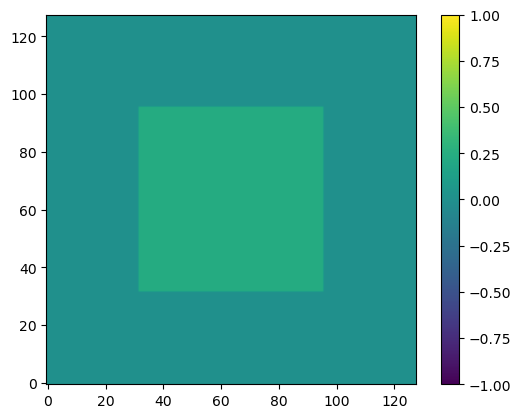

In [18]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
out_field = numpy_numba_sin_pointwise(in_field, out_field)
plot_field(out_field)

In [19]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
numpy_numba_sin_pointwise(in_field, out_field)

341 ms ± 4.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Curiosuly, the code with loops is faster than using the numpy functions without loops. In particular, we observe that `array_numba_parallel_sin_pointwise()` is **~8x faster** than `numpy_numba_sin_pointwise()`.

| Function                               | Time   |
|:---------------------------------------|-------:|
| `list_sin_pointwise()`                 | 2.51s  |
| `array_sin_pointwise()`                | 7.94s  |
| `numpy_sin_pointwise()`                | 348ms  |
| `array_numba_sin_pointwise()`          | 353ms  |
| `array_numba_parallel_sin_pointwise()` | 41.5ms |
| `numpy_numba_sin_pointwise()`          | 359ms  |

In conclusion, the best way to use Numba (at lest for the pointwise stencil) seems to keep all the `for` loops, avoid using the numpy functions, and take advantage of all the cores by passing `parallel=True` to the `@njit` decorator.

# 1D stencils

With the lessons learned from the pointwise stencil, now we will focus on using numpy arrays keeping the `for` loops and checking whether we still need to keep in mind the right order of the loops or if Numba can do that for us.

###  Same column: $a(i,j) = \frac{1}{2} \Big[b(i+1,j) - b(i,j)\Big]$

## Arrays with loops

In [20]:
@jit(nopython=True, parallel=True)
def array_numba_parallel_1D_same_col_row_update(in_field, out_field):
    for iter in range(N_ITER):
        for k in prange(NZ):
            for i in range(NX - 1):
                for j in range(NY):
                    out_field[k, j, i] = 0.5 * (in_field[k, j, i+1] - in_field[k, j, i])
                    # Periodic boundary condition
                    out_field[k, j, NX-1] = 0.5 * (in_field[k, j, 0] - in_field[k, j, NX-1])
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field

    return out_field

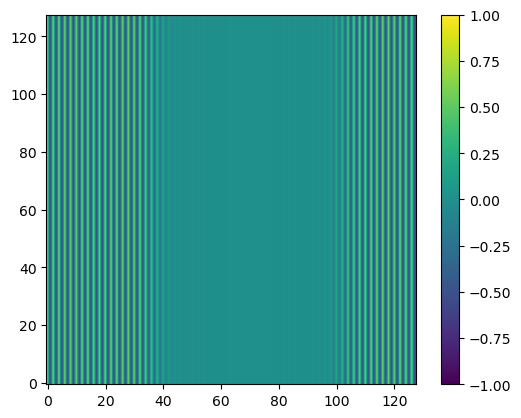

In [21]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars")
out_field = array_numba_parallel_1D_same_col_row_update(in_field, out_field)
plot_field(out_field)

In [22]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars")
array_numba_parallel_1D_same_col_row_update(in_field, out_field)

24.8 ms ± 483 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
@jit(nopython=True, parallel=True)
def array_numba_parallel_1D_same_col_col_update(in_field, out_field):
    for iter in range(N_ITER):
        for k in prange(NZ):
            for j in range(NY):
                for i in range(NX - 1):
                    out_field[k, j, i] = 0.5 * (in_field[k, j, i+1] - in_field[k, j, i])
                    # Periodic boundary condition
                out_field[k, j, NX-1] = 0.5 * (in_field[k, j, 0] - in_field[k, j, NX-1])
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

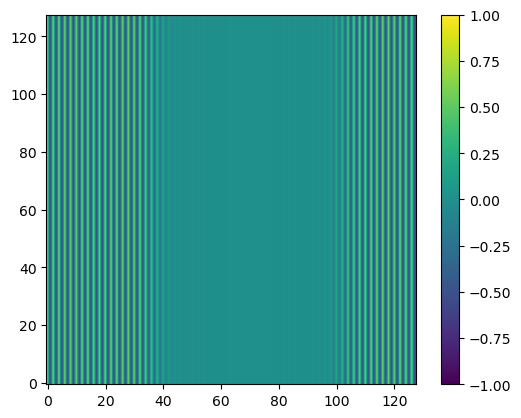

In [24]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars")
out_field = array_numba_parallel_1D_same_col_col_update(in_field, out_field)
plot_field(out_field)

In [25]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars")
array_numba_parallel_1D_same_col_col_update(in_field, out_field)

17.7 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Arrays without loops

In [26]:
@jit(nopython=True)
def numpy_numba_1D_same_col(in_field, out_field):    
    for iter in range(N_ITER):
        out_field[:, :, :-1] = 0.5 * (in_field[:, :, 1:] - in_field[:, :, :-1])
        # Periodic boundary condition
        out_field[:, :, -1] = 0.5 * (in_field[:, :, 0] - in_field[:, :, -1])
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field

    return out_field

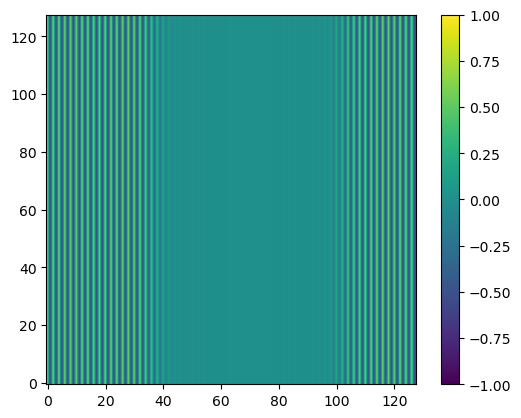

In [27]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars")
out_field = numpy_numba_1D_same_col(in_field, out_field)
plot_field(out_field)

In [28]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars", order="C")
numpy_numba_1D_same_col(in_field, out_field)

77.4 ms ± 877 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="vertical-bars", order="F")
numpy_numba_1D_same_col(in_field, out_field)

528 ms ± 4.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


| Function                                        | Time   |
|:-----------------------------------------------:|-------:|
| `list_1D_same_col_row_update()`                 | 8.03s  |
| `list_1D_same_col_col_update()`                 | 3.24s  |
| `array_1D_same_col_row_update()`                | 25.7s  |
| `array_1D_same_col_col_update()`                | 12.1s  |
| `numpy_1D_same_col_order_C()`                   | 56.7ms |
| `numpy_1D_same_col_order_F()`                   | 34ms   |
| `array_numba_parallel_1D_same_col_row_update()` | 24.5ms |
| `array_numba_parallel_1D_same_col_col_update()` | 17.5ms |
| `numpy_numba_1D_same_col_order_C()`             | 76.1ms |
| `numpy_numba_1D_same_col_order_F()`             | 527ms  |

The summary of this table and main conclusion is that Numba can speedup the code but updating the field in the right order is still relevant. Numba code is **~2x faster** than the numpy code, and updating the field in the right order further speeds up the code **~40%**.

Using Numba against pure numpy code without `for` loops only decreases performance. And in this case it is surprising to see that trying to use the right col-wise (Fortran style) initialization for the arrays makes the code **~7x** slower than with the default (C style) initialization.

## Same row: $a(i,j) = \frac{1}{2} \Big[b(i,j+1) - b(i,j)\Big]$

## Arrays with loops

In [30]:
@jit(nopython=True, parallel=True)
def array_numba_parallel_1D_same_row_row_update(in_field, out_field):
    for iter in range(N_ITER):
        for k in prange(NZ):
            for i in range(NX):
                for j in range(NY-1):
                    out_field[k, j, i] = 0.5 * (in_field[k, j+1, i] - in_field[k, j, i])
                out_field[k, NY-1, i] = 0.5 * (in_field[k, 0, i] - in_field[k, NY-1, i])
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

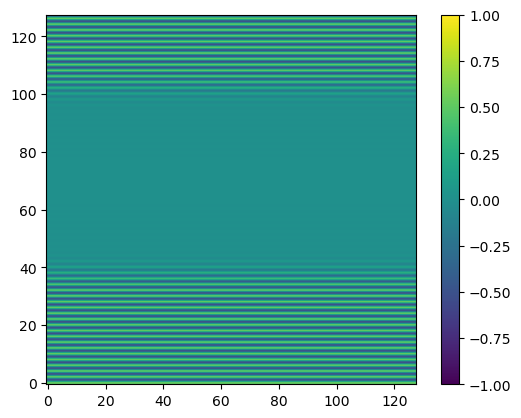

In [31]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars")
out_field = array_numba_parallel_1D_same_row_row_update(in_field, out_field)
plot_field(out_field)

In [32]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars")
array_numba_parallel_1D_same_row_row_update(in_field, out_field)

21.2 ms ± 219 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
@jit(nopython=True, parallel=True)
def array_numba_parallel_1D_same_row_col_update(in_field, out_field):
    for iter in range(N_ITER):
        for k in prange(NZ):
            for j in range(NY - 1):
                for i in range(NX):
                    out_field[k, j, i] = 0.5 * (in_field[k, j+1, i] - in_field[k, j, i])
                    out_field[k, NY-1, i] = 0.5 * (in_field[k, 0, i] - in_field[k, NY-1, i])
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field
        
    return out_field

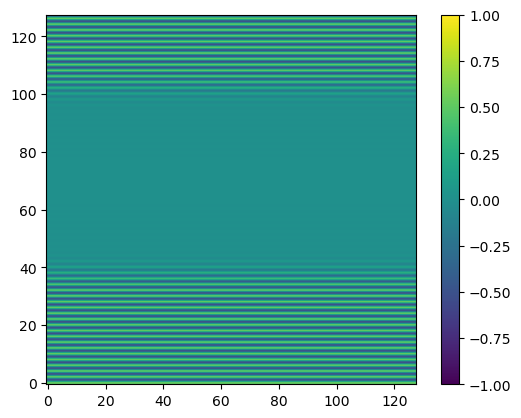

In [34]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars")
out_field = array_numba_parallel_1D_same_row_col_update(in_field, out_field)
plot_field(out_field)

In [35]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars")
array_numba_parallel_1D_same_row_col_update(in_field, out_field)

18 ms ± 73 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Weird result!! Double check**. The wrong order of updating the field is actually a bit faster than the correct order, which in this case.

## Arrays without loops

In [36]:
@jit(nopython=True)
def numpy_numba_1D_same_row(in_field, out_field):    
    for iter in range(N_ITER):
        out_field[:, :-1, :] = 0.5 * (in_field[:, 1:, :] - in_field[:, :-1, :])
        # Periodic boundary condition
        out_field[:, -1, :] = 0.5 * (in_field[:, 0, :] - in_field[:, -1, :])
        
        if iter < N_ITER - 1:
            in_field, out_field = out_field, in_field

    return out_field

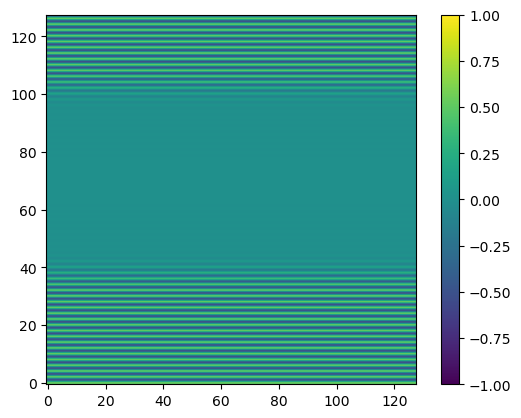

In [37]:
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars")
out_field = numpy_numba_1D_same_row(in_field, out_field)
plot_field(out_field)

In [38]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars", order="C")
numpy_numba_1D_same_row(in_field, out_field)

76.4 ms ± 451 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="horizontal-bars", order="F")
numpy_numba_1D_same_row(in_field, out_field)

562 ms ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 2D field

The 4th-order diffusion we used in the course is the right stencil to test the `@stencil` decorator.

In [4]:
from stencil2d import laplacian, update_halo, apply_diffusion

This is the compact laplacian function rewritten using the `@stencil` decorator. It is very simple to write stencils with Numba, but unfortunately at the moment there is not a simple way to implement the periodic boundary conditions. In the future it may be possible using the `func_or_mode` parameter. With current latest version of Numba only `func_or_mode="constan"` is supported, which means that the elements of the field outside a valid range are considered constant with the value `cval`.

In [23]:
@stencil
def laplacian_numba(in_field):
    return -4.0 * in_field[0, 0, 0] + in_field[0, -1, 0] \
           + in_field[0, 1, 0] + in_field[0, 0, -1] + in_field[0, 0, 1]

Let's verify that it does the same transformation to the field as `laplacian()` from `stencil2d`.

True

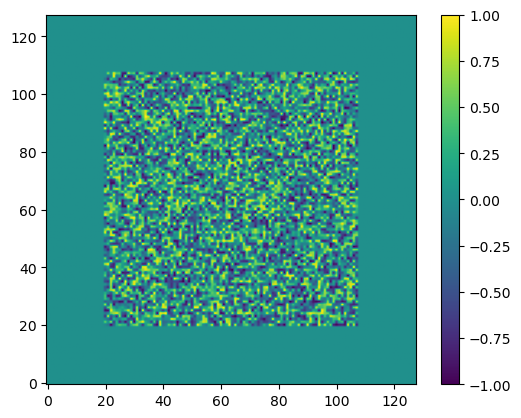

In [24]:
field, copy_field = initialize_fields(NX, NY, NZ, mode="random", num_halo=20)
plot_field(field)
np.array_equal(field, copy_field)

In [30]:
lap_field = np.empty_like(field)
laplacian(field, lap_field, num_halo=20, extend=0)

In [26]:
lap_field_numba = laplacian_numba(field)

In [32]:
np.testing.assert_array_almost_equal(lap_field, lap_field_numba)

In [34]:
%timeit laplacian(field, lap_field, num_halo=2, extend=0)

7.25 ms ± 161 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
%timeit laplacian_numba(field)

292 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The Numba stencil code is much slower because the `@stencil` decorator does not compile anything. It just transforms the compact code using relative coordinates into a python function with the absolute indices. The speedup can only be obtain later combining this function with `@jit`.

In order to have periodic boundaries we have to use the same trick as done in the `stencil2d.py` module, i.e., write a new `update_halo()` function. This time we write this function with `for` loops to fully benefit from the Numba "magic". We can use the `prange` on the Z axis, and reuse some of the loops.

In [36]:
@jit(nopython=True, parallel=True)
def update_halo_numba(field, num_halo):
    for k in prange(NZ):
        for j in range(num_halo):
            for i in range(NX - 2 * num_halo):
                # updating top edge (without corners)
                field[k, j, num_halo + i] = field[k, NY - 2 * num_halo + j, num_halo + i]
                # updating bottom edge (without corners)
                field[k, NY - num_halo + j, num_halo + i] = field[k, num_halo + j, num_halo + i]
        for j in range(NY):
            for i in range(num_halo):
                # updating left edge (with corners)
                field[k, j, i] = field[k, j, NX - 2 * num_halo + i]
                # updating right edge (with corners)
                field[k, j, NX - num_halo + i] = field[k, j, num_halo + i]

Let's tests the `update_halo_numba()` against the implementation from `stencil2d.py`.

True

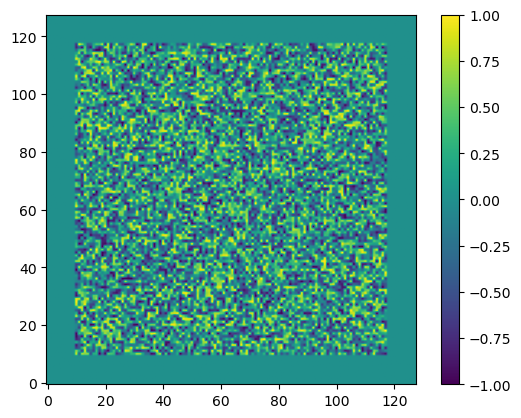

In [57]:
field, copy_field = initialize_fields(NX, NY, NZ, mode="random", num_halo=10)
plot_field(field)
np.array_equal(field, copy_field)

False

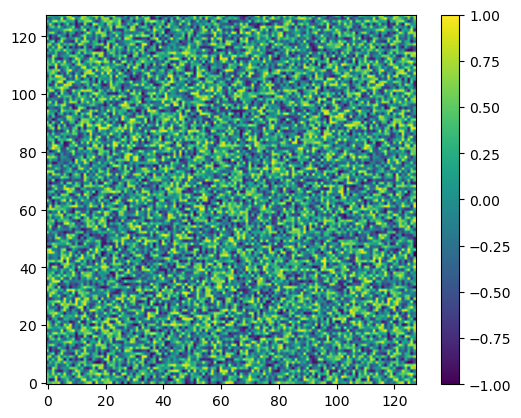

In [58]:
update_halo(field, num_halo=10)
plot_field(field)
np.array_equal(field, copy_field)

True

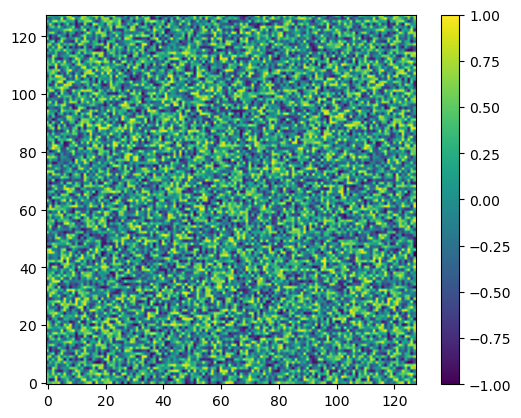

In [59]:
update_halo_numba(copy_field, num_halo=10)
plot_field(copy_field)
np.array_equal(field, copy_field)

Let's now verify that the `update_halo_numba()` is at least as fast as `update_halo()`

In [60]:
%%timeit
field, copy_field = initialize_fields(NX, NY, NZ, mode="random")
update_halo(field, num_halo=2)

7.2 ms ± 117 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [62]:
%%timeit
field, copy_field = initialize_fields(NX, NY, NZ, mode="random")
update_halo_numba(field, num_halo=2)

7.37 ms ± 84.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


There is not a noticeable speedup in this case, but at least we have not make the numpy code worse.

In [84]:
@jit(nopython=True, parallel=True)
def apply_diffusion_numba(in_field, num_halo, num_iter=1):
    alpha = 1.0 / 32.0
    tmp_field = np.empty_like(in_field)

    for n in range(num_iter):
        update_halo_numba(in_field, num_halo)

        # TODO: this is not exactly the same as the original code because of the extend
        # Probably we cannot use the @stencil decorator after all because we cannot implement the extend in that way
        tmp_field = laplacian_numba(in_field, num_halo=num_halo)
        out_field = laplacian_numba(tmp_field, num_halo=num_halo)

        for k in prange(NZ):
            for j in range(NY - 2 * num_halo):
                for i in range(NX - 2 * num_halo):
                    out_field[k, num_halo + j, num_halo + i] = \
                        in_field[k, num_halo + j, num_halo + i] - alpha * out_field[k, num_halo + j, num_halo + i]

        if n < num_iter - 1:
            in_field, out_field = out_field, in_field
        else:
            update_halo_numba(out_field, num_halo)

    return out_field

In [79]:
in_field, _ = initialize_fields(NX, NY, NZ, mode="square")
out_field = apply_diffusion_numba(in_field, num_halo=2, num_iter=N_ITER)

In [82]:
%%timeit
in_field, out_field = initialize_fields(NX, NY, NZ, mode="square")
apply_diffusion(in_field, out_field, num_halo=2, num_iter=N_ITER)

966 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [83]:
%%timeit
in_field, _ = initialize_fields(NX, NY, NZ, mode="square")
out_field = apply_diffusion_numba(in_field, num_halo=2, num_iter=N_ITER)

378 ms ± 17.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The difussion stencil is **~2.5x faster** with the Numba code than with the base numpy code.

# Conclusions

- Numba is very easy to use
- Numba makes "normal" python code with Numpy arrays faster
- It is easy to parallelize the code and even avoid Python’s global interpreter lock (GIL) with `parallel=True` and `prange`
- Numba makes NumPy "vectorial" code slower (this agrees with some numbers from the Numba docs, e.g., section 1.14.2)
- It is not always clear if there is a gain or not, one has to do a test every time with and without `@njit`
- **Weird result**: in the 1D stencil, the wrong order is faster than the right order in the same row case.

# TODO
- [ ] Fix correctness of diffusion stencil with Numba
- [ ] Try @cuda.jit